# Data Preparation and Data Cleaning

### EDA Observation: -
There are few ideas for Machine learning point of you: -
1. As we are having pickup records for full jan2015, we can segment pickup time for some interval (like 10 minutes, 20 minutes) and forecast for future intervals.
2. we have total fare and using this feature we can segment it for week or got s day and can-do forecasting of total revenue for future week or day.
3. we have geographical data pickup and drop latitude and longitude, now we can do clustering for various small region of NY and predict number of pickups on various time interval like 10 mint, 1hr, or day interval, so that can guide drivers where need stand for quickly services.
4. We have history trip duration and speed; we can forecast possible trip duration for any pickup.


## # ML Problem Formulation
Now Based on above point we are going to solve below challenge using ML
<p>Time-series forecasting and Regression</p>
To find number of pickups, given location coordinates(latitude and longitude) and time, in the query religion and surrounding regions..
 
To solve the above we would be using data collected in 1-Jan-2015 to 20-jan-2015 as training set and for test rest of jan2015 data .


### In this part we will do:-
1. Data cleaning:- removes all outliers which we observe during EDA
2. We have geographical data pickup and drop latitude and longitude based on that we will Segment using Clustering.


In [1]:
# Import all used packages
import pandas as pd
import folium #open street map

import datetime
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg') # for more intractive visualization like zoom out
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Load data
file = test_data_file = "../data-set/yellow_tripdata_2015-01.csv"
all_data = pd.read_csv(file)

In [3]:
#jan_data = all_data.loc[all_data.tpep_pickup_datetime.str.startswith("2019-1")]
print("Jan2019 data row and columns informantion")
print(all_data.shape)
print(all_data.columns)

Jan2019 data row and columns informantion
(12748986, 19)
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
jan_data = all_data[
                    ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                     'passenger_count', 'trip_distance', 'pickup_longitude',
                     'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 
                     'fare_amount','total_amount']
                   ]
del(all_data)

In [5]:
#Conver python date formate type into unix time format to deal better way as unix's time is presents in Seconds
jan_data["pickup_time_unix"] = jan_data.tpep_pickup_datetime.apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))
jan_data["dropoff_time_unix"] = jan_data.tpep_dropoff_datetime.apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))

In [6]:
#Make New Trip Duration feature using pickup and dropoff time
jan_data["trip_duration"] = (jan_data['dropoff_time_unix'].astype(int) - jan_data['pickup_time_unix'].astype(int))/float(60)

In [7]:
#Make New Trip Speed feature for analysis
jan_data["speed"] = 60*(jan_data["trip_distance"]/jan_data["trip_duration"])

In [8]:
#Sorting data frame as 
jan_data.sort_values(["pickup_time_unix","dropoff_time_unix"], inplace=True)

## 1. Data cleaning:-
removing outliers

In [9]:
pre_len = len(jan_data)
print("Number of pickup records before data cleaning = {0}".format(str(len(jan_data))))
jan_data = jan_data[((jan_data.dropoff_longitude >= -74.15) & (jan_data.dropoff_longitude <= -73.7004) &\
                       (jan_data.dropoff_latitude >= 40.5774) & (jan_data.dropoff_latitude <= 40.9176)) & \
                       ((jan_data.pickup_longitude >= -74.15) & (jan_data.pickup_latitude >= 40.5774)& \
                       (jan_data.pickup_longitude <= -73.7004) & (jan_data.pickup_latitude <= 40.9176))]
    
jan_data = jan_data[(jan_data.trip_duration > 0) & (jan_data.trip_duration < 720)]
jan_data = jan_data[(jan_data.trip_distance > 0) & (jan_data.trip_distance < 23)]
jan_data = jan_data[(jan_data.speed < 45.31) & (jan_data.speed > 0)]
jan_data = jan_data[(jan_data.total_amount <1000) & (jan_data.total_amount >0)]
post_len = len(jan_data)
                                                                   
print("****************************************************")                                                                   
print("Number of pickup records After data cleaning = {0}".format(str(len(jan_data))))
                                                                  
                                                                  
print("fraction of data points that remain after removing outliers",
      float(post_len)/pre_len)

Number of pickup records before data cleaning = 12748986
****************************************************
Number of pickup records After data cleaning = 12371076
fraction of data points that remain after removing outliers 1.0


## 2. Clustering/Segmentation:-
<p>Using K-means clustering will do area segmentation </p>
we need to choose number of clusters so that, there are more number of cluster regions, that are close to any cluster center
and make sure that the minimum inter cluster should not be very less

In [10]:
#trying different cluster sizes to choose the right K in K-means
coords = jan_data[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    jan_data['pickup_cluster'] = kmeans.predict(jan_data[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.913529551356517 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6732497108049906 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.4434531747207122 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distance 

### Observation:-
We can see optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters is 0.44 mile at cluster size of  30.
So we will make location cluster of 30
<p>Why 0.4 mile as min distance?:- because if taxi need to move from one place to other there should be not very less distance or not too far, at least he can manage to drive for 10 mintus.</p>

In [11]:
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
jan_data['pickup_cluster'] = kmeans.predict(jan_data[['pickup_latitude', 'pickup_longitude']])

In [78]:
kmean_model_file = "../model/kmean_cluster_model.sav"
with open(kmean_model_file,'wb') as file_obj:
    pickle.dump(kmeans, file_obj)

<IPython.core.display.Javascript object>


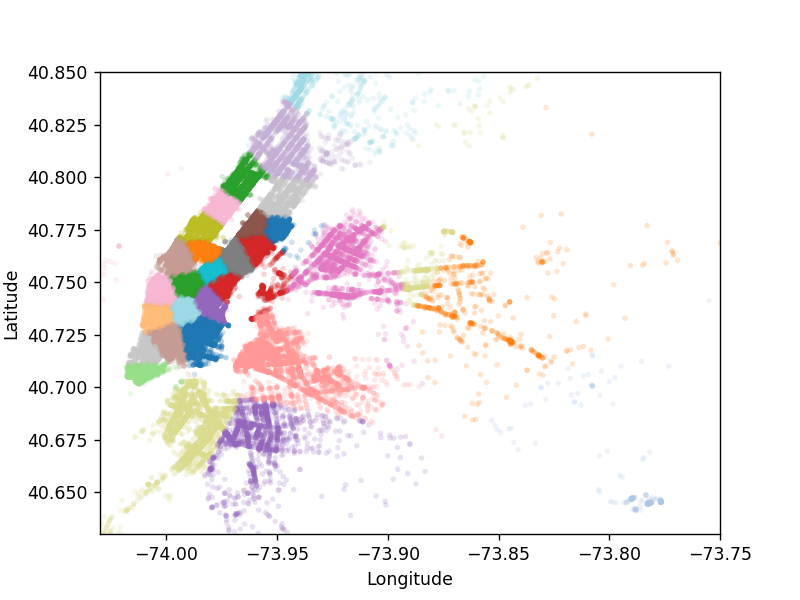

In [12]:
#Visualising the clusters on a map
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.scatter(jan_data.pickup_longitude.values[:100000], jan_data.pickup_latitude.values[:100000], s=10, lw=0,
               c=jan_data.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### 10 Minuts Interval Time Binning

In [13]:
#Refer:https://www.unixtimestamp.com/
start_unix_time = 1420070400
#1575158400 : 2019-01-12 00:00:00

jan_data["10_min_bin"] = jan_data["pickup_time_unix"].apply(lambda x : int(abs((x-start_unix_time)/(60*10))))
jan_2015_groupby_10m = jan_data[["pickup_cluster","10_min_bin","trip_distance"]].groupby(["pickup_cluster","10_min_bin"]).count()


In [14]:
jan_2015_groupby_10m.head()

trip_distance
pickup_cluster 10_min_bin               
0              0                      72
               1                      66
               2                      66
               3                      68
               4                      90

4430

In [40]:
max_bin_each_cluster = max(jan_data["10_min_bin"])
print("number of 10min intravels among all the clusters:-"+str(len(jan_2015_groupby_10m)) + "and for each cluser= "+str(max_bin_each_cluster))
#there are 169947 combination of 30 cluster and 10 mint bin

number of 10min intravels among all the clusters:-131125and for each cluser= 4430


In [38]:
jan_data["10_min_bin"]

-4430.998333333333

####  Lets find out for each group if there is any 0 pickups

In [ ]:
#Max possible bin for 10 mint is 4430

In [ ]:
jan_data[["pickup_cluster","10_min_bin"]].groupby(["pickup_cluster",]).count()

In [74]:
zero_pickup = 4431*30 - len(jan_2015_groupby_10m)
print("Number of zero pickups groups:-"+str(zero_pickup))

Number of zero pickups groups:-1805


####  Observation:-
as we can see there is 1805 zero pickup 10 mints slots so we need to go either filling or Smoothing

### filling or Smoothing:-
Smoothing is techniques to fill some value when there will be 0 occurance bin.
<p>Initial we will fill 0 and later when we will build some basic model then will predict values for that bin and will fill predicted values</p>
<p>We will do filling in training data set only not in test set, see more in modeling part</p>

###  Zero Filling:-


In [77]:
new_data_dict =[]
data_index = list(jan_2015_groupby_10m.index.values)
for clust in range(30):
    for slot in range(4430):
        if not (clust,slot) in data_index:
            new_data_dict.append([0,0,clust,slot])

In [ ]:
new_data_dict

In [ ]:
jan_data[["pickup_time_unix","trip_distance", "pickup_cluster", "10_min_bin"]].append(filled_data,ignore_index=True,)

### Final plot on cleaned data

<IPython.core.display.Javascript object>


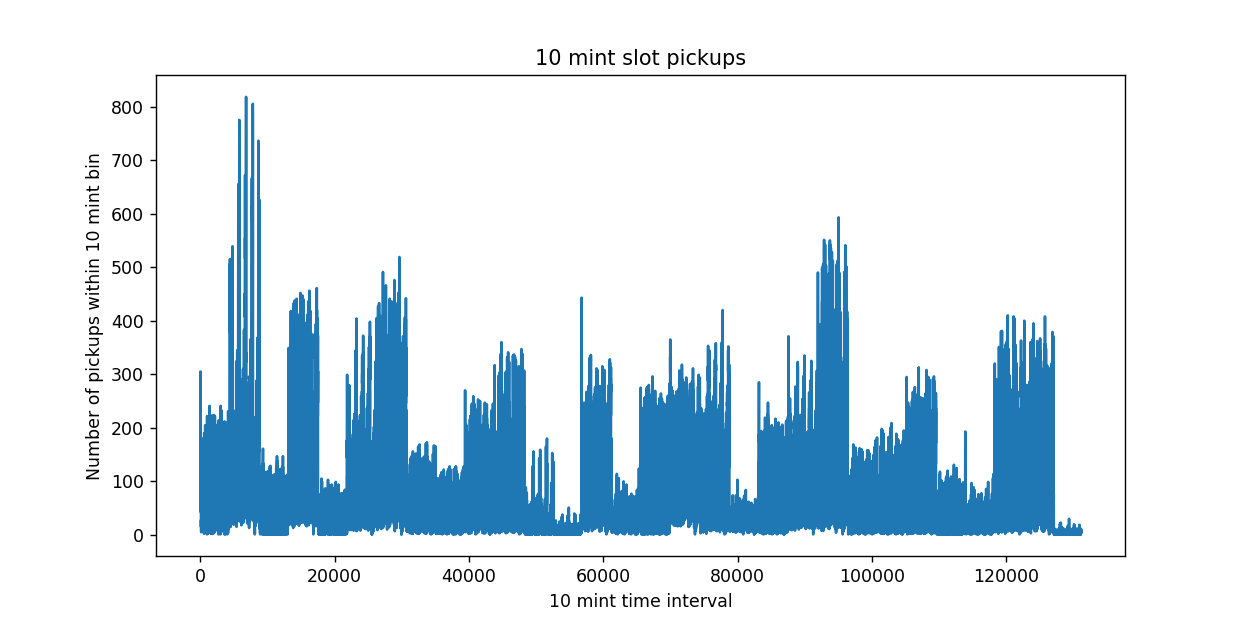

In [17]:
plt.figure(figsize=(10,5))
plt.plot(range(len(jan_2015_groupby_10m)),jan_2015_groupby_10m)
plt.xlabel("10 mint time interval")
plt.ylabel("Number of pickups within 10 mint bin")
plt.title("10 mint slot pickups")
plt.show()

### Observation:-
We can see in some region number of pickups is very high and some region is low

In [18]:
jan_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,total_amount,pickup_time_unix,dropoff_time_unix,trip_duration,speed,pickup_cluster,10_min_bin
8166863,2015-01-01 00:00:00,2015-01-01 00:11:26,5,4.00,-73.971436,40.760201,-73.921181,40.768269,13.5,14.5,1.420051e+09,1.420051e+09,11.433333,20.991254,21,33
8166886,2015-01-01 00:00:01,2015-01-01 00:03:49,1,0.80,-73.860847,40.757294,-73.868111,40.752285,5.0,6.3,1.420051e+09,1.420051e+09,3.800000,12.631579,4,32
5048596,2015-01-01 00:00:03,2015-01-01 00:10:50,1,1.58,-73.987579,40.765270,-73.976921,40.776970,9.0,12.2,1.420051e+09,1.420051e+09,10.783333,8.791345,3,32
8166887,2015-01-01 00:00:03,2015-01-01 00:21:48,2,2.57,-73.969017,40.754269,-73.994133,40.761600,14.5,15.8,1.420051e+09,1.420052e+09,21.750000,7.089655,21,32
5048597,2015-01-01 00:00:04,2015-01-01 00:10:44,3,2.50,-73.957008,40.774502,-73.966019,40.800617,10.5,11.8,1.420051e+09,1.420051e+09,10.666667,14.062500,15,32


#### Export jan_data with  trip_distance, pickup_cluster,10_min_bin and pickup_time_unixcolumns only as we will use only these feature for further model biulding.


In [19]:
#file = r"D:\Lekhraj_data\lekhraj\Learning Material\Applied AI courses\Python for data science\44_CASE_STUDY_3TAXI_DEMAND_PREDICTION_IN_NEW_YORK_CITY\clean_train_test_yellow_tripdata_2015-01.csv"
#jan_data[["pickup_time_unix","trip_distance", "pickup_cluster", "10_min_bin"]].to_csv(file, index=False)